In [1]:
# Cambiare policy su powershell : Set-ExecutionPolicy remotesigned
from Functions_General import clear_folder_content, province_to_region, get_calendar, province_italian_to_english
from Functions_Energy_Model import get_coordinates
import pandas as pd
import yaml
import plotly.graph_objects as go
import dataframe_image as dfi
import glob
from datetime import datetime
import os
from plotly.subplots import make_subplots
import numpy as np
import xlwings as xw
from pvlib import solarposition
import matplotlib.pyplot as plt
from simple_colors import *

In [2]:
print(blue("\nCreate report:", ['bold', 'underlined']), '\n')


Create report: 



In [3]:
global num_graph, flag_show, detailed_report

In [4]:
config = yaml.safe_load(open("config.yml", 'r'))

In [5]:
repor_yaml = yaml.safe_load(open(config["filename_report"], 'r'))

In [6]:
flag_show = repor_yaml['flag_show']
num_graph = 0
detailed_report = True

In [7]:
name_months = ['GEN', 'FEB', 'MAR', 'APR', 'MAG', 'GIU', 'LUG', 'AGO', 'SET', 'OTT', 'NOV', 'DIC']

In [8]:
filename_CACER_energy_monthly = config['filename_CACER_energy_monthly']
foldername_graphs_energy = config['foldername_graphs_energy']
foldername_graphs = config['foldername_graphs']
foldername_result_energy = config["foldername_result_energy"]
foldername_graphs_generali = config["foldername_graphs_generali"]
foldername_graphs_finance = config["foldername_graphs_finance"]

day_winter = config["day_winter"]
day_summer = config["day_summer"]

recap = yaml.safe_load(open(config["filename_recap"], 'r'))
utenti = yaml.safe_load(open(config["filename_registry_users_yml"], 'r'))
user_types = yaml.safe_load(open(config["filename_registry_user_types_yml"], 'r'))

foldername_result_finance = config["foldername_result_finance"]
case_denomination = recap["case_denomination"]

charts = yaml.safe_load(open(foldername_graphs + "layout_charts.yml", 'r'))
col = charts["colors"]

user_set = recap["list_user_types"]
user_type_list_consuming = recap["list_types_prosumers"] + recap["list_types_consumers"]
prosumers = recap["list_types_prosumers"]

In [9]:
# remove all pictures from previous simulations
clear_folder_content(foldername_graphs_energy)
clear_folder_content(foldername_graphs_finance)
clear_folder_content(foldername_graphs_generali)

All files in assets\\energy\\ folder deleted
All files in assets\\finance\\ folder deleted
All files in assets\\general\\ folder deleted


In [10]:
# tale funzione consente di plottare rapidamente un grafico di tipo scatter

def plot_scatter(x, y, title, title_y, output_file):
    fig = go.Figure(go.Scatter(x=x, y=y, mode='lines'))
    fig.update_layout(
        title_text = title, 
        # xaxis = dict(title='Ora', 
                    #  rangeslider=dict(visible=True), type='date')
                    # )
    )
    fig.update_layout(plot_bgcolor='white',
        legend = dict(orientation='h',
                        yanchor="top", y = -0.25, xanchor="left", x=0.01), 
                    )
    fig.update_yaxes(title_text = title_y)
    if flag_show:
        fig.show()
    fig.write_html(output_file + ".html")
    fig.write_image(output_file + ".png", width=1000, height=1200/13.2*5, scale = 4)

In [13]:
# si crea un df con le denominazioni per i vari utenti (saranno usate queste denominazioni nei grafici!)

filename_utenze_xls = config['filename_users_CACER_xls'] # si importa il nome del file .xls contenente gli utenti da simulare (tutte le tipologie di utenza!)

# si apre il file excel e si importa il foglio "utenti" in un df
wb = xw.Book(filename_utenze_xls)
df = wb.sheets["Utenti"].range('A1').options(pd.DataFrame, 
                                            header=1,
                                            index=False, 
                                            expand='table').value
wb.close() # si chiude il file excel

assert len(df.user_type.unique()) == len(df.user_type), "some user_type share the same ID!" # si verifica che lo user ID sia unico per ogni utente
df.set_index("user_type", inplace=True) # si setta lo user ID come index
df.drop(columns=["number_type_id"],inplace=True) # si elimina la prima colonna
df.num = df.num.fillna(0).astype(int) # si annulla la numerosità di tutti gli utenti

denomination_users = df.denomination.copy()

for user in user_type_list_consuming:
    denomination_users_list = []
    denomination_users_list.append(denomination_users[user])

## Generali

Tabella tipologie utenti

In [ ]:
# si leggono le caratteristiche della configurazione in esame e si crea una tabella riassuntiva da aggiungere al report

df = pd.read_excel(config["filename_users_CACER_xls"], sheet_name="Utenti") # si legge il foglio excel contenente le caratteristiche della configurazione in esame

df = df[df["num"] > 0] # togliamo le tipologie di utenti che non sono inclusi nella simulazione
df = df[df["flag"] == True] # togliamo le tipologie di utenti che non sono inclusi nella simulazione

# si eliminano dal df tutte le colonne non necessarie
df.drop(columns=["number_type_id","flag","consuming","producing","wind","error",
                 "power_range", "supplier", "tariff",
                 "flag_cacer", "disbursement_month", "commissioning_month", "entry_month", "exit_month", "CP", "location", "denomination",
                 "dummy_user", "grant_private", 
                 "new_plant", "pv_mounting", "stakeholder", "condominium", "mv_cabinet", "tilt_angle", "azimuth"
                 ],inplace=True)

# si rinominano le colonne con dei label più adatti alla stesura del report
df.rename(columns={"user_type_id":"Tipo utente", "num": "Utenti", "type":"Tipologia", "category":"Categoria",
                #    "power_range":"Classe potenza", "supplier":"Fornitore","tariff":"Schema tariffario", 
                   "load_profile_id":"Tipologia carico",
                   "pv":"Capacità PV", "battery":"Capacità accumulo",
                #    "new_plant":"Nuovo impianto",
                   "funding_scheme":"Modello Finanziamento",
                   "grant_pnrr":"Fondo PNRR",
                   "debt":"Quota di debito",
                   "voltage":"Livello tensione"}, inplace=True)

# si definisce una funzione che assegna un colore in base alla tipologia di utente (prosumer; producer; consumer)
def color_tipologia(value):
    if value == "prosumer":
        color = col["arancione"]
    elif value == "producer":
        color = col["blu"]
    else:
        color = col["verde"]
    return 'color: %s' % color

# si definisce una funzione che assegna un colore in base alla tipologia di utenza (domestico; industriale; pubblico; commerciale)
def color_categoria(value):
    if value == "domestico":
        color = col["rosso"]
    elif value == "industriale":
        color = col["violetto"]
    elif value == "pubblico":
        color = col["azzurro"]
    else: 
        color = col["marrone"]
    return 'color: %s' % color

df.reset_index(drop=True, inplace=True)
# Apply styling to dataframe 
# ,na_rep=""

# si definisce una tabella riassuntiva con le principali informazioni relative alla configurazione in esame

if detailed_report:

    styled_df = df.style.format(precision=0, thousands=".", decimal=",",na_rep="")\
        .set_caption("Tabella riassuntiva degli utenti della comunità divisi per tipologia")\
        .format_index(str, axis=1)\
        # .applymap(color_tipologia, subset=['Tipologia'])\
        # .bar(subset=["Capacità PV"], color=col["blu"],vmax=sum(x if not pd.isna(x) else 0 for x in df["Capacità PV"]))\
        # .bar(subset=["Capacità accumulo",], color=col["rosso"],vmax=sum(x if not pd.isna(x) else 0 for x in df["Capacità accumulo"]))\
        # .bar(subset=["Utenti"], color=col["giallo"], vmax=sum(df["Utenti"]))\
        # .applymap(color_categoria, subset=['Categoria'])\
        # .hide(axis="index")

        # .relabel_index(["row 1", "row 2"], axis=0)
        # {":.2f"}%})
        # .hide_index() \
    # .bar(subset=["Tipologia",], color='lightgreen')
    # .applymap(color_tipologia, subset=['Tipologia'])

    styled_df.set_properties(subset=['Utenti'], **{'width': '80px'})
    styled_df.set_properties(subset=['Capacità PV'], **{'width': '80px'})
    styled_df.set_properties(subset=['Capacità accumulo'], **{'width': '60px'})
    # styled_df.set_properties(subset=['Nuovo impianto'], **{'width': '50px'})
    styled_df.set_properties(subset=['Livello tensione'], **{'width': '50px'})
    # styled_df.set_properties(subset=['Classe potenza'], **{'width': '50px'})
    # styled_df.set_properties(subset=['Schema tariffario'], **{'width': '50px'})

    # si genera e si salva la tabella definita sopra

    path = foldername_graphs_generali
    num_table = 0
    title = 'CACER_users_table.png'

    # ATTENTION: the following line stopped working due to library issues
    # https://stackoverflow.com/questions/75687844/problem-with-dataframe-image-no-such-file-or-directory-appdata-local-tem
    # dfi.export(styled_df, path + str(num_table) + "_" + title dpi = 550) # This only works for styled dataframes

    # As a temporary solution, the following works but losing the coloring
    dfi.export(styled_df, path + str(num_table) + "_" + title, table_conversion='matplotlib')
    styled_df

Grafico andamento prelievi annuali per tipologia utente 

In [15]:
df = pd.read_csv(config["filename_carichi"]) # si legge il grafico contenente le informazioni circa i consumi elettrici

df["year"] = df["datetime"].str[:4]
df.drop(columns="datetime",inplace=True)
df_yearly = df.groupby("year").sum()

df_yearly = df_yearly[user_type_list_consuming] # teniamo solo gli users che ci servono, uno per tipo, nell'ordine che abbiamo dato 
colors = {"prosumer":"orange",
        "consumer":"blue"} 

if detailed_report: # usually not needed

    for i, user in enumerate(user_type_list_consuming):
        
        title = 'Andamento consumi per tipologia utenti: ' + denomination_users[str(user)]

        fig = go.Figure()
        
        fig.add_trace(go.Bar(
            x = df_yearly.index, y = df_yearly[user]/1000, 
            # marker_color = colors[utenti[user]["type"]], 
            name = str(denomination_users[str(user)]) + " (" + str(user_types[str(user)]["type"]) +")",
            text=round(df_yearly[user]/1000,1), textposition='auto',
            ))

        fig.update_layout(
            title_text = title, 
            xaxis = dict(title='anni',
            # type='category'
            ),
            yaxis = dict(title='MWh/anno'))

        fig.update_layout(plot_bgcolor='white',
                    legend = dict(orientation='h',
                                yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                                )

        if flag_show: fig.show()

        path = foldername_graphs_generali
        num_graph+=1
        title = 'Andamento consumi per tipologia utenti ' + denomination_users[user]

        fig.write_html(path + str(num_graph) + "_" + title + ".html")
        fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

Grafico confronto prelievo annuale nell'anno 1 per tipologia utente 

In [16]:
valori_anno_1 = df_yearly.iloc[0]

title = 'Consumi per tipologia utenti - Anno 1'

colors = {"prosumer":"orange",
          "consumer":"blue"} 

x = user_type_list_consuming.copy()
for i, value in enumerate(x):
    x[i] = denomination_users[value]

fig = go.Figure(go.Bar(
    x = x, 
    y = valori_anno_1/1000, 
    # marker_color = colors[user_types[user]["type"]], 
    # name = denomination_users_list,
    text=round(valori_anno_1/1000,1), textposition='auto',
    ))

fig.update_layout(plot_bgcolor='white',
    title_text = title, 
    xaxis = dict(title='anni',
    # type='category'
    ),
    yaxis = dict(title='MWh/anno'))

fig.update_layout(
            legend = dict(orientation='h',
                          yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                        )

if flag_show: fig.show()

path = foldername_graphs_generali
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

Curve di carico venerdi+sab+domenica

In [17]:
cal = get_calendar()
friday_flag = 0
count = 0
while friday_flag == 0: #cerciamo un venerdi che abbia un carico normale non da vacanza
    if cal.loc[count,"day_week"] == 4: friday_flag = 1
    else: count += 1 #count è l'indice della mezzanotte del primo venerdi della serie, che usiamo per plottare i profili

In [18]:
df = pd.read_csv(config["filename_carichi"])
df = df[count:count+96*3]
df.set_index("datetime",inplace=True)

if detailed_report:
    for user in user_type_list_consuming:

        title = "Esempio curve di carico di tre giorni (giorno feriale, sabato e domenica): " + str(denomination_users[user])

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x = df.index, 
            y = df[user]*4, 
            # marker_color = colors[user_types[user]["type"]], 
            name = denomination_users[str(user)],
            # text=round(df[user]*4,1), textposition='auto',
            ))
        
        fig.update_layout(plot_bgcolor='white',
            title_text = title, 
            xaxis = dict(title='orario',
            # type='category'
            ),
            yaxis = dict(title='Potenza impiegata (kW)'))
        
        fig.update_layout(
                    legend = dict(orientation='h',
                                yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                                )

        if flag_show: fig.show()
        
        path = foldername_graphs_generali
        num_graph+=1
        title = "Esempio curve di carico di tre giorni (giorno feriale, sabato e domenica)" + str(denomination_users[user])

        fig.write_html(path + str(num_graph) + "_" + title + ".html")
        fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

Grafico distribuzione consumi suddiviso per categorie di utenza

Grafico utenze industriali

In [19]:
df = pd.read_csv(config["filename_carichi"])
df = df[count:count+96*3]
df.set_index("datetime",inplace=True)

user_type_list_industrial = [user_type for user_type in user_types if user_types[user_type]["category"] == "industriale" and user_types[user_type]["num"]>0 and user_types[user_type]["dummy_user"] != True]

if user_type_list_industrial != []:

    fig = go.Figure()

    for user in user_type_list_industrial:

        title = "Esempio curve di carico di tre giorni (giorno feriale, sabato e domenica) utenze industriali"

        fig.add_trace(go.Scatter(
            x = df.index, 
            y = df[user]*4, 
            # marker_color = colors[utenti[user]["type"]], 
            name = denomination_users[str(user)],
            # text=round(df[user]*4,1), textposition='auto',
            ))
        
        fig.update_layout(plot_bgcolor='white',
            title_text = title, 
            xaxis = dict(title='orario',
            # type='category'
            ),
            yaxis = dict(title='Potenza impiegata (kW)'))
        
        fig.update_layout(
                    legend = dict(orientation='h',
                                yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                                )

    title_1 = "Esempio curve di carico di tre giorni utenze industriali"

    if flag_show: fig.show()

    path = foldername_graphs_generali
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

Grafico utenze NON industriali

In [20]:
greys = [
    # 'rgb(255,255,255)',
    # 'rgb(240,240,240)',
    'rgb(217,217,217)',
    'rgb(189,189,189)',
    'rgb(150,150,150)',
    'rgb(115,115,115)',
    'rgb(82,82,82)',
    'rgb(37,37,37)',
    'rgb(0,0,0,0.5)',
    'rgb(0,0,0,1)',
    'rgb(0,0,0,0.1)',
    ]

lines = ['solid', 'dot', 'dash', 
         'longdash', 
         'dashdot', 
         'longdashdot', 
         'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot']

In [21]:
count = count + 24*4*7*2 # saltiamo di 2 settimane

In [22]:
df = pd.read_csv(config["filename_carichi"])

df = df[count:count+96*3]
df.set_index("datetime",inplace=True)

user_type_list_non_industrial = [user_type for user_type in user_types if user_types[user_type]["category"] != "industriale" and user_types[user_type]["num"]>0]
# user_type_list_non_industrial.reverse()

if detailed_report:

    if user_type_list_non_industrial != []:

        fig = go.Figure()

        for i, user_type in enumerate(user_type_list_non_industrial):
            # print(user_type)

            title = "Esempio curve di carico di tre giorni (giorno feriale, sabato e domenica)"
            # title = "Load profiles samples (Working Day, Saturday and Sunday) per type of user"

            fig.add_trace(go.Scatter(
                x = df.index, 
                y = df[user_type]*4, 
                # marker_color = colors[user_types[user_type]["type"]], 
                # marker_color = greys[i],
                name = denomination_users[str(user_type)],
                # text=round(df[user_type]*4,1), textposition='auto',
                mode='lines',
                # line=dict(dash=lines[i]),
                ))
            
            fig.update_layout(plot_bgcolor='white',
                # bgcolor = "darkgrey",
                
                title_text = title, 
                # xaxis = dict(title='orario',
                xaxis = dict(title='Time',
                # type='category'
                ),
                # yaxis = dict(title='Potenza impiegata (kW)'))
                yaxis = dict(title='Power (kW)'))
            
            fig.update_layout(
                        legend = dict(orientation='h',
                                    yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                                    )

        if flag_show: fig.show()

        path = foldername_graphs_generali
        num_graph+=1

        fig.write_html(path + str(num_graph) + "_" + title + ".html")
        fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*6, scale = 4)


        fig.write_image(config["foldername_graphs_energy"] + title + ".png", width=1000, height=1100/13.2*5, scale = 4)
    

Andamento mensile e stagionalità

In [ ]:
# a barre e a colori
df = pd.read_csv(config["filename_carichi"])
df["year"] = df["datetime"].str[:4]
df["month"] = df["datetime"].str[5:7]
df = df[df["year"] == df.loc[0,"year"]] #prendiamo solo il primo anno
df_monthly = df.drop(columns=["datetime","year"]).groupby("month").sum()

fig = go.Figure()

title = "Andamento mensile dei consumi ed effetto della stagionalità per tipologia di utenti"

for i, user in enumerate(user_type_list_consuming):
    fig.add_trace(go.Bar(
        # x = df_monthly.index, 
        x = name_months,
        y = df_monthly[user]/1000, 
        # marker_color = greys[i],
        # marker_color = colors[utenti[user]["type"]], 
        name = denomination_users[user],
        # text=round(df_monthly[user]/1000,1), textposition='outside',
        ))
    
    fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # xaxis = dict(title='Month',
        # type='category'
        ),
        # yaxis = dict(title='MWh per month'))
        yaxis = dict(title='MWh al mese'))
    
    fig.update_layout(
                legend = dict(orientation='h',
                            yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                            )

if flag_show: fig.show()

path = foldername_graphs_generali
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

fig.write_image(config["foldername_graphs_energy"] + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

Tabella riassuntiva consumi mensili

In [ ]:
# ci ricreiamo l'aggregato mensile ma solo delle tipologie di utenti, non di tutti
df_table = df_monthly.copy()
df_table = df_table[user_type_list_consuming] #facciamo una selezione degli utenti attivi

df_table["Totale CACER"] = 0
for user in user_type_list_consuming:
    df_table["Totale CACER"] += df_table[user].multiply(user_types[user]["num"], axis="index") # sommiamo l'aggregato di tutti gli utenti di quel tipo

for user in df_table.columns:
    if user in user_type_list_consuming:
        df_table.rename(columns={str(user) : str(denomination_users[str(user)])}, inplace=True)

if flag_show: df_table

In [25]:
# si assegna uno stile alla tabella creata in precedenza

# more here: https://www.analyticsvidhya.com/blog/2021/06/style-your-pandas-dataframe-and-make-it-stunning/

if detailed_report:
    df_table.loc['Total'] = df_table.sum(numeric_only=True)
    df_table.index.rename("Mese", inplace=True)

    styled_df = df_table.style.format(precision=1, thousands=".", decimal=",") \
        .format_index(str, axis=1)\
        .set_caption("Consumi anno 1 per tipologia di utente (kWh/mese)") \
        .background_gradient()

    path = foldername_graphs_generali
    num_table+=1
    title = 'CACER 2tabella.png'

    # dfi.export(styled_df, path + "table_" + str(num_table) + "_" + title, dpi = 150) # This only works for styled dataframes
    dfi.export(styled_df, path + "table_" + str(num_table) + "_" + title,  table_conversion='matplotlib')
    styled_df

Consumi mensili differenziati per utente

In [26]:
totale_mensile_tutti_utenti = df_table["Totale CACER"]

fig = go.Figure()
# title = "Aggregato mensile dei consumi considerando tutti gli utenti della CACER"
title = "CACER aggregated monthly energy demand"

for user in user_type_list_consuming:
    for i in range(user_types[user]["num"]):
        fig.add_trace(go.Bar(
            x = df_monthly.index,
            # x = name_months, 
            y = df_monthly[user]/1000, 
            # marker_color = colors[utenti[user]["type"]], 
            name = str(denomination_users[str(user)]) + '_' + str(i+1),
            # text=round(df_monthly[user]/1000,1), textposition='auto',
            ))
        fig.update_layout(plot_bgcolor='white',
            title_text = title, 
            xaxis = dict(title='Month',
            # type='category'
            ),
            yaxis = dict(title='MWh/month'))
        fig.update_layout(
                    legend = dict(orientation='h',
                                yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                                )
fig.update_layout(barmode='stack')

#aggiungiamo linea trasparente per indicare il totale a numero
fig.add_trace(go.Scatter(
        x = df_monthly.index,
        # x = name_months,
        y = totale_mensile_tutti_utenti/1000, 
        marker_color= 'rgba(255, 0, 0, 0)', 
        mode='markers+text',
        name = "Total",
        text=round(totale_mensile_tutti_utenti/1000,1), textposition='top center',
        ))

if flag_show: fig.show()

path = foldername_graphs_generali
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
if len(user_type_list_consuming) > 10: fig.update_layout(showlegend=False) #se abbiamo troppi utenti mutiamo la legenda dal png, che altrimenti non si legge nulla
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

In [ ]:
if detailed_report:
    title = "Plots sun chart 1"
    plt.ioff() # turn off interactive mode

    # lat, lon, tilt_angle, azimuth = get_coordinates()  
    name_location = str(province_italian_to_english())
    lat, lon = get_coordinates(name_location)
    lat = float(lat) #float is required
    lon = float(lon) #float is required

    tz='Europe/Rome'

    times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', 
                        #   closed='left',
                        freq='H', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

    ax = plt.subplot(1, 1, 1, projection='polar')
    # draw the analemma loops
    points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                        s=2, label=None, c=solpos.index.dayofyear)
    ax.figure.colorbar(points)

    # draw hour labels
    for hour in np.unique(solpos.index.hour):
        # choose label position by the smallest radius for each hour
        subset = solpos.loc[solpos.index.hour == hour, :]
        r = subset.apparent_zenith
        pos = solpos.loc[r.idxmin(), :]
        ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

    # draw individual days
    for i, date in enumerate(pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21'])):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
        solpos = solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        #label = date.strftime('%Y-%m-%d')
        labels = ['Equinoxes','Solstice March','Solstice December']
        ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=labels[i])

    ax.figure.legend(loc='upper left')

    # change coordinates to be like a compass
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rmax(90)

    num_graph+=1
    plot_saved = plt.savefig(config["foldername_graphs_generali"] + str(num_graph) + "_" + title + ".png", bbox_inches = 'tight')

    if flag_show: plt.show() # after plt.show() is called, a new figure is created

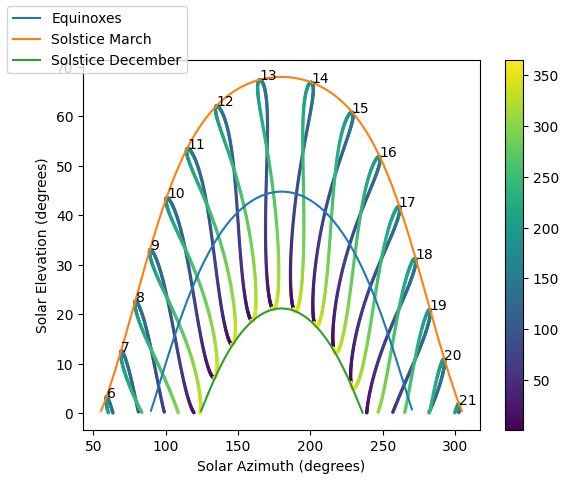

In [ ]:
if detailed_report:
    title = "Plots sun chart 2"

    name_location = str(province_italian_to_english())
    lat, lon = get_coordinates(name_location)
    lat = float(lat) #float is required
    lon = float(lon) #float is required

    tz='Europe/Rome'

    times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', 
                        #   closed='left',
                        freq='H', tz=tz)

    solpos = solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

    fig, ax = plt.subplots()
    points = ax.scatter(solpos.azimuth, solpos.apparent_elevation, s=2,
                        c=solpos.index.dayofyear, label=None)
    fig.colorbar(points)

    for hour in np.unique(solpos.index.hour):
        # choose label position by the largest elevation for each hour
        subset = solpos.loc[solpos.index.hour == hour, :]
        height = subset.apparent_elevation
        pos = solpos.loc[height.idxmax(), :]
        ax.text(pos['azimuth'], pos['apparent_elevation'], str(hour))

    for i, date in enumerate(pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21'])):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
        solpos = solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        #label = date.strftime('%Y-%m-%d')
        labels = ['Equinoxes','Solstice March','Solstice December']
        ax.plot(solpos.azimuth, solpos.apparent_elevation, label=labels[i])

    ax.figure.legend(loc='upper left')
    ax.set_xlabel('Solar Azimuth (degrees)')
    ax.set_ylabel('Solar Elevation (degrees)')

    num_graph+=1

    plot_saved = plt.savefig(config["foldername_graphs_generali"] + str(num_graph) + "_" + title + ".png", bbox_inches = 'tight')

    
    if flag_show: plt.show() # after plt.show() is called, a new figure is created

## CACER

Sankey flussi energetici intera CACER

In [29]:
df = pd.read_excel(filename_CACER_energy_monthly, sheet_name="CACER")

In [30]:
def plot_sankey(df, user):
  global num_graph, data
  df["Eprel_non_cond"] = df["Eprel"] - df["Econd"]
  df["Evend_non_cond"] = df["Eimm"] - df["Econd"]

  Eaut_tot = df["Eaut"].sum() # energia autoconsumata totale
  Eimm_tot = df["Eimm"].sum() # energia immessa totale
  Eut_tot = df["Eut"].sum() # energia consumata totale
  Econd_tot = df["Econd"].sum() # energia condivisa totale
  Eprod_tot = df["Eprod"].sum() # energia prodotta totale
  Eprel_tot = df["Eprel"].sum() # energia prelevata totale
  Eprel_non_cond_tot = df["Eprel"].sum() - df["Econd"].sum() # energia prelevata non condivisa totale
  Evend_non_cond_tot = df["Eimm"].sum() - df["Econd"].sum() # energia venduta non condivisa totale
  Eperdite_tot = df["Eperdite"].sum() # perdite di energia

  ## ITALIANO
  data = {
      "Econd": {"value": Econd_tot, "col": col["verde"],"label": "Energia condivisa"},
      "Eprod": {"value": Eprod_tot,"col": col["giallo"],"label": "Energia prodotta dalla CACER"},
      "Evend_non_cond": {"value": Evend_non_cond_tot,"col": col["blu"],"label": "Energia immessa non condivisa"},
      "Eperdite": {"value": Eperdite_tot,"col": col["marrone"],"label": "Perdite conversione"},
      "Eprel_non_cond": {"value": Eprel_non_cond_tot,"col": col["rosso"],"label": "Energia prelevata non condivisa"},
      "Eprel": {"value": Eprel_tot,"col": col["rosso"],"label": "Energia prelevata da rete"},
      "Eaut": {"value": Eaut_tot,"col": col["arancione"],"label": "Energia autoconsumata"},
      "Eut": {"value": Eut_tot,"col": col["violetto"],"label": "Energia consumata dalla CACER"},
      "Eimm": {"value": Eimm_tot,"col": col["blu"],"label": "Energia immessa e venduta in rete"},         
      }


  ## INGLESE
  # data = {
  #     "Econd": {"value": Econd_tot, "col": col["verde"],"label": "Shared Energy"},
  #     "Eprod": {"value": Eprod_tot,"col": col["giallo"],"label": "CACER Energy Produced"},
  #     "Evend_non_cond": {"value": Evend_non_cond_tot,"col": col["blu"],"label": "Energy injected into the grid and not share"},
  #     "Eperdite": {"value": Eperdite_tot,"col": col["marrone"],"label": "Energy Losses"},
  #     "Eprel_non_cond": {"value": Eprel_non_cond_tot,"col": col["rosso"],"label": "Energy purchased from grid and not shared"},
  #     "Eprel": {"value": Eprel_tot,"col": col["rosso"],"label": "Energy purchased from grid"},
  #     "Eaut": {"value": Eaut_tot,"col": col["arancione"],"label": "Self_consumed energy"}, 
  #     "Eut": {"value": Eut_tot,"col": col["violetto"],"label": "CACER Energy Demand"},
  #     "Eimm": {"value": Eimm_tot,"col": col["blu"],"label": "Energy injected and sold to grid"},            
  #     }

  flows = pd.read_excel(foldername_graphs + "sankey_inputs.xlsx", sheet_name="CER")

  """Plot the Sankey with the energy flows
  more info: https://plotly.com/python/sankey-diagram/
  """
  title = "Energy flows - " +  user

  fig = go.Figure(data=[go.Sankey(
      valuesuffix = "kWh",
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [data["Eprod"]["label"], # node 0 = prod,
                data["Eaut"]["label"], # node 1 = aut,
                data["Eut"]["label"], # node 2 = consumi,
                data["Eimm"]["label"], # node 3 = immessa in rete e venduta ,
                data["Econd"]["label"], # node 4 = condivisa
                data["Eprel"]["label"], # node 5 = prelevata da rete e acquistata da fornitore
                data["Evend_non_cond"]["label"],  # node 6 = venduta ma non condivisa,
                data["Eperdite"]["label"], # node 7 = perdite
                data["Eprel_non_cond"]["label"], # node 8 = prelevata da rete ma non condivisa
                ], 
        color = [data["Eprod"]["col"], # node 0 = prod,
                data["Eaut"]["col"], # node 1 = aut,
                data["Eut"]["col"], # node 2 = consumi,
                data["Eimm"]["col"], # node 3 = immessa in rete e venduta ,
                data["Econd"]["col"], # node 4 = condivisa
                data["Eprel"]["col"], # node 5 = prelevata da rete e acquistata da fornitore
                data["Evend_non_cond"]["col"],  # node 6 = venduta ma non condivisa,
                data["Eperdite"]["col"], # node 7 = perdite
                data["Eprel_non_cond"]["col"], # node 8 = prelevata da rete ma non condivisa
                ], 
      ),
      link = dict(
        source = flows["source"],
        target = flows["target"],
        value = [data[flows.loc[i,"value"]]["value"] for i in range(len(flows["value"]))], # andiamo a prendere il valore del dizionario data corrispondente al nome dato nel csv
        color = [data[flows.loc[i,"color"]]["col"] for i in range(len(flows["color"]))], # stessa cosa di sopra ma per il colore
        # label  = ["%.2f" % data[flows.loc[i,"value"]]["value"] for i in range(len(flows["value"]))]
    ))])

  fig.update_layout(title_text=title, font_size=10)

  if flag_show: fig.show()

  path = foldername_graphs_energy
  num_graph+=1

  fig.write_html(path + str(num_graph) + "_" + title + ".html")
  fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)
  
plot_sankey(df, user="CACER")

Diagramma a torta mix energetico CACER su energia consumata

In [31]:
fills = ["o","x","/"]

In [32]:
def plot_pie_consumption(df,  user):
  global num_graph, Eaut_tot, Econd_tot, Eprel_non_cond_tot
  title = "Allocazione dell'energia consumata [%] - " +  user
  labels = ['Energia Autoconsumata dai prosumer', 'Energia Condivisa dalla CACER ', 'Energia Acquistata da rete non condivisa']

  # title = "CACER Energy consumption allocation - [%]"
  # labels = ['Prosumers energy self-consumption', 'Energy purchased from grid and shared', 'Energy purchased from grid and not shared']
  
  Eaut_tot = df["Eaut"].sum() # energia autoconsumata totale
  Econd_tot = df["Econd"].sum() # energia condivisa totale
  Eprel_non_cond_tot = df["Eprel"].sum() - df["Econd"].sum() # energia prelevata non condivisa totale
  
  values_kWh = [Eaut_tot,Econd_tot,Eprel_non_cond_tot]

  fig = go.Figure(data=[go.Pie(labels=labels, values=values_kWh, pull=[0.05, 0.05, 0.05])])

  fig.update_layout(title_text = title)

  fig.update_traces(marker=dict(colors=[col["arancione"], col["verde"], col["rosso"]]))
  # fig.update_traces(marker=dict(colors=[greys[0],greys[2], greys[4]]))

  fig.update_layout(
              legend = dict(orientation='h',
                            yanchor="top", y = -0.1, xanchor="left", x=0.01), 
                          )


  path = foldername_graphs_energy
  num_graph+=1

  fig.write_html(path + str(num_graph) + "_" + title + ".html")
  fig.write_image(path + str(num_graph) + "_" + title + ".png", width=500, height=500, scale = 4)
  if flag_show: fig.show()

  fig.write_image(config["foldername_graphs_energy"] + title + ".png", width=500, height=500, scale = 4)

plot_pie_consumption(df,  user="CACER")

Diagramma a torta mix energetico CACER su energia prodotta

In [33]:
def plot_pie_generation(df, user):
  global num_graph, Eaut_tot, Econd_tot, Evend_non_cond_tot
  title = "Allocazione dell'energia prodotta [%] - " + user
  labels = ['Energia autoconsumata dai prosumer', 'Energia venduta in rete e condivisa con la CACER', 'Energia venduta in rete non condivisa']

  # title = "CACER Energy generation allocation - [%]"
  # labels = ['Prosumers energy self-consumption', 'Energy sold to grid and shared', 'Energy sold to grid and not shared']
  
  Eaut_tot = df["Eaut"].sum() # energia autoconsumata totale
  Econd_tot = df["Econd"].sum() # energia condivisa totale
  Evend_non_cond_tot = df["Eimm"].sum() - df["Econd"].sum() # energia venduta non condivisa totale

  values_kWh = [Eaut_tot, Econd_tot, Evend_non_cond_tot]

  fig = go.Figure(data=[go.Pie(labels=labels, values=values_kWh, pull=[0.05, 0.05, 0.05])])

  fig.update_layout(title_text = title)

  fig.update_traces(marker=dict(colors=[col["arancione"], col["verde"], col["blu"]]))
  # fig.update_traces(marker=dict(colors=[greys[0],greys[2], greys[4]]))

  fig.update_layout(
              legend = dict(orientation='h',
                            yanchor="top", y = -0.1, xanchor="left", x=-0.01), 
                          )

  path = foldername_graphs_energy
  num_graph+=1

  fig.write_html(path + str(num_graph) + "_" + title + ".html")
  fig.write_image(path + str(num_graph) + "_" + title + ".png", width=500, height=500, scale = 4)
  if flag_show: fig.show()

  fig.write_image(config["foldername_graphs_energy"] + title + ".png", width=500, height=500, scale = 4)

plot_pie_generation(df, user="CACER")

Grafico aree mix energetico CACER su energia consumata

In [34]:
def plot_area_lifetime_consumption(df, user):
    global num_graph
    title = 'Ripartizione energia consumata mensilmente [%] - ' + user
    # labels = ['Energia Autoconsumata dai prosumer', 'Energia acquistata da rete e condivisa dalla CACER', 'Energia Acquistata da rete non condivisa']
    # title = "CACER Energy consumption allocation - [%]"
    # labels = ['Prosumers energy self-consumption', 'Energy purchased from grid and shared', 'Energy purchased from grid and not shared']
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    for i in ["Eaut","Econd","Eprel_non_cond"]:

        ################ IN PERCENTUALE
        y_perc = df[i] / (df["Eaut"] + df["Econd"] + df["Eprel_non_cond"]) * 100
        fig.add_trace(go.Scatter(
            x = df.month, 
            y = y_perc, 
            marker_color = data[i]["col"], 
            name = data[i]["label"],
            text=round(y_perc,1), textposition='middle center',
            stackgroup='one',
            ),
            secondary_y= True)

        #     ########## QUESTO È IN MWH 
        # fig.add_trace(go.Bar(
        #     x = df_last_year.month, 
        #     y = df_last_year[i]/1000, 
        #     marker_color = data[i]["col"], 
        #     name = data[i]["label"],
        #     text=round(df_last_year[i]/1000,1), textposition='auto',
        #     ))

    fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # type='category'
        ))

    fig.update_layout(
                legend = dict(orientation='h',
                            yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                            )

    fig.update_layout(barmode='stack')

    fig.update_yaxes(title_text = 'Prelievi in MWh', secondary_y=False, exponentformat= "none")

    fig.update_yaxes(title_text = 'Percentuale sui prelievi (%)', secondary_y=True, exponentformat= "none",
        mirror=True,
        # ticks='outside',
        showline=True,
        # linecolor='black',
        gridcolor='lightgrey')

    if flag_show: fig.show()


    path = foldername_graphs_energy
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

plot_area_lifetime_consumption(df, user="CACER")

In [35]:
def plot_area_year1_consumption(df, user):
    global num_graph

    df["year"] = df.month.str[:4]
    df_last_year = df.copy()
    df_last_year = df_last_year[df_last_year["year"] == df_last_year["year"][0]]
    df_last_year["Percentuale autoconsumo"] = df_last_year["Eaut"] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Eprel_non_cond"])
    df_last_year["Percentuale condivisione"] = df_last_year["Econd"] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Eprel_non_cond"])
    df_last_year["Percentuale prelievo senza condivisione"] = df_last_year["Eprel_non_cond"] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Eprel_non_cond"])

    title = 'Ripartizione energia consumata nel primo anno [%] - ' + user
    labels = ['Energia Autoconsumata dai prosumer', 'Energia acquistata da rete e condivisa dalla CACER', 'Energia Acquistata da rete non condivisa']
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    for i in ["Eaut","Econd","Eprel_non_cond"]:

        ################ IN PERCENTUALE
        y_perc = df_last_year[i] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Eprel_non_cond"]) * 100
        fig.add_trace(go.Scatter(
            x = df_last_year.month, 
            y = y_perc, 
            marker_color = data[i]["col"], 
            name = data[i]["label"],
            text=round(y_perc,1), textposition='middle center',
            stackgroup='one',
            ),
            secondary_y= True)

        #     ########## QUESTO È IN MWH 
        # fig.add_trace(go.Bar(
        #     x = df_last_year.month, 
        #     y = df_last_year[i]/1000, 
        #     marker_color = data[i]["col"], 
        #     name = data[i]["label"],
        #     text=round(df_last_year[i]/1000,1), textposition='auto',
        #     ))

    fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # type='category'
        ))

    fig.update_layout(
                legend = dict(orientation='h',
                            yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                            )

    fig.update_layout(barmode='stack')

    fig.update_yaxes(title_text = 'Prelievi in MWh', secondary_y=False, exponentformat= "none")

    fig.update_yaxes(title_text = 'Percentuale sui prelievi (%)', secondary_y=True, exponentformat= "none",
        mirror=True,
        # ticks='outside',
        showline=True,
        # linecolor='black',
        gridcolor='lightgrey')

    if flag_show: fig.show()

    path = foldername_graphs_energy
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

plot_area_year1_consumption(df, user="CACER")

Grafico aree mix energetico CACER su energia prodotta

In [36]:
def plot_area_lifetime_generation(df, user):
    global num_graph
    title = "Ripartizione energia prodotta nell'intero progetto - " + user
    labels = ['Energia Autoconsumata dai prosumer', 'Energia prodotta e condivisa dalla CACER', 'Energia prodotta e non condivisa']
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    for i in ["Eaut","Econd","Evend_non_cond"]:

        ################ IN PERCENTUALE
        y_perc = df[i] / (df["Eaut"] + df["Econd"] + df["Evend_non_cond"]) * 100
        fig.add_trace(go.Scatter(
            x = df.month, 
            y = y_perc, 
            marker_color = data[i]["col"], 
            name = data[i]["label"],
            text=round(y_perc,1), textposition='middle center',
            stackgroup='one',
            ),
            secondary_y= True)

        #     ########## QUESTO È IN MWH 
        # fig.add_trace(go.Bar(
        #     x = df_last_year.month, 
        #     y = df_last_year[i]/1000, 
        #     marker_color = data[i]["col"], 
        #     name = data[i]["label"],
        #     text=round(df_last_year[i]/1000,1), textposition='auto',
        #     ))

    fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # type='category'
        ))

    fig.update_layout(
                legend = dict(orientation='h',
                            yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                            )

    fig.update_layout(barmode='stack')

    fig.update_yaxes(title_text = 'Prelievi in MWh', secondary_y=False, exponentformat= "none")

    fig.update_yaxes(title_text = 'Percentuale sulle produzioni (%)', secondary_y=True, exponentformat= "none",
        mirror=True,
        # ticks='outside',
        showline=True,
        # linecolor='black',
        gridcolor='lightgrey')

    if flag_show: fig.show()

    path = foldername_graphs_energy
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

plot_area_lifetime_generation(df, user="CACER")

In [37]:
def plot_area_year1_generation(df, user):
    global num_graph
    
    df["year"] = df.month.str[:4]
    df_last_year = df.copy()
    df_last_year = df_last_year[df_last_year["year"] == df_last_year["year"][0]]
    df_last_year["Percentuale autoconsumo"] = df_last_year["Eaut"] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Evend_non_cond"])
    df_last_year["Percentuale condivisione"] = df_last_year["Econd"] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Evend_non_cond"])
    df_last_year["Percentuale produzione senza condivisione"] = df_last_year["Evend_non_cond"] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Evend_non_cond"])

    title = 'Ripartizione energia prodotta nel primo anno - ' + user
    labels = ['Energia Autoconsumata dai prosumer', 'Energia prodotta e condivisa dalla CACER', 'Energia prodotta e non condivisa']
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    for i in ["Eaut","Econd","Evend_non_cond"]:

        ################ IN PERCENTUALE
        y_perc = df_last_year[i] / (df_last_year["Eaut"] + df_last_year["Econd"] + df_last_year["Evend_non_cond"]) * 100
        fig.add_trace(go.Scatter(
            x = df_last_year.month, 
            y = y_perc, 
            marker_color = data[i]["col"], 
            name = data[i]["label"],
            text=round(y_perc,1), textposition='middle center',
            stackgroup='one',
            ),
            secondary_y= True)

        #     ########## QUESTO È IN MWH 
        # fig.add_trace(go.Bar(
        #     x = df_last_year.month, 
        #     y = df_last_year[i]/1000, 
        #     marker_color = data[i]["col"], 
        #     name = data[i]["label"],
        #     text=round(df_last_year[i]/1000,1), textposition='auto',
        #     ))

    fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # type='category'
        ))

    fig.update_layout(
                legend = dict(orientation='h',
                            yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                            )

    fig.update_layout(barmode='stack')

    fig.update_yaxes(title_text = 'Prelievi in MWh', secondary_y=False, exponentformat= "none")

    fig.update_yaxes(title_text = 'Percentuale sulle produzioni (%)', secondary_y=True, exponentformat= "none",
        mirror=True,
        # ticks='outside',
        showline=True,
        # linecolor='black',
        gridcolor='lightgrey')

    if flag_show: fig.show()

    path = foldername_graphs_energy
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

plot_area_year1_generation(df, user="CACER")

In [38]:
df = pd.read_csv(config["filename_CACER_energy_hourly"]).fillna(0)

In [39]:
# ENERGY FLOW FOR ALL CACER!
df = pd.read_csv(config["filename_CACER_energy_hourly"]).fillna(0)

line_shape = 'linear' # hv, vh, hvh, vhv, spline, linear

labels = {"Eaut":'Energia Autoconsumata dai prosumer', 
          "Econd":'Energia condivisa dalla CACER', 
          "Eprel": 'Energia prelevata e non condivisa',
          "Eimm": 'Energia immessa e non condivisa',
          "Eperdite": "Perdite conversione"}

# labels = {"Eaut":'Prosumers energy self-consumption', 
#           "Econd":'Energy shared with the CACER', 
#           "Eprel": 'Energy purchased from grid and not shared',
#           "Eimm": 'Energy injected into the grid and not shared',
#           "Eperdite": "Energy Losses"}

for active_day_str in ["day_spring", "day_summer", "day_autumn","day_winter"]:

    active_day = str(config[active_day_str]) # deve essere una stringa, non un datetime.data

    title = "Flussi energetici - " + active_day + " - CACER "
    
    df_plot = df[[string.startswith(active_day) for x,string in enumerate(df["dayhour"])]] 
    assert len(df_plot) > 0, active_day + " not found! Check inputs"
    assert len(df_plot) <= 24*4, active_day + "has too may datapoints! Investigate"

    df_plot = df_plot.set_index("dayhour")

    # togliamo cio che non ci serve
    # df_plot.drop(columns=["battery_cumulative_charge","SOCkWh","SOCperc","LCF_aut","SCF_aut","Eprod","Eaut_PV", "Eaut_batt"], inplace=True, errors="ignore")
    # fixing order of columns, needed for the stacked area chart
    df_plot = df_plot[["Eut", "Eprod", "Eaut", "Econd",  "Eimm", "Eprel", "Eperdite"]]

    df_plot["Eprel"] = df_plot["Eprel"] - df_plot["Econd"] # diventa solo la quota non condivisa
    df_plot["Eimm"] = df_plot["Eimm"] - df_plot["Econd"] # diventa solo la quota non condivisa

    # # se siamo a base quartoraria, dobbiamo allora passare da kWh/quartodora a kW, moltiplicando per 4
    # if config["delta_t"] in ["15min", "15Min"]:
    #     print("Quarterly!")
    #     df_plot = df_plot * 4 

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x = df_plot.index, y = df_plot["Eut"], marker_color=data["Eut"]["col"], mode='lines+markers',
                name = data["Eut"]["label"], 
                line_shape = line_shape,
                textposition='top center',stackgroup=None))
    
    fig.add_trace(go.Scatter(
        x = df_plot.index, y = df_plot["Eprod"], marker_color=data["Eprod"]["col"], mode='lines+markers',
                name = data["Eprod"]["label"], 
                line_shape = line_shape,
                textposition='top center',stackgroup=None))
    
    # tutte queste sono cumulate, quindi stacked area
    for column in df_plot.columns:
        if column == "datetime" or column in ["Eut", "Eprod"]: continue
        fig.add_trace(go.Scatter(
            x = df_plot.index, y = df_plot[column], marker_color=data[column]["col"], mode='lines',
                    name = labels[column], 
                    line_shape = line_shape,
                    textposition='top center',stackgroup='one'))

    fig.update_layout(
        title_text = title, 
        # xaxis = dict(title='Ora', 
                    #  rangeslider=dict(visible=True), type='date')
                    # )
    )

    fig.update_layout(
        legend = dict(orientation='h',
                        yanchor="top", y = -0.25, xanchor="left", x=0.01), 
                    )
    fig.update_yaxes(title_text = "Power (kW)")

    ##############################################################################################################################

    fig.update_xaxes(
        # mirror=True,
        # ticks='outside',
        # showline=True,
        # linecolor='lightgrey',
        gridcolor='white'
    )

    fig.update_yaxes(
        # mirror=True,
        # ticks='outside',
        # showline=True,
        # linecolor='lightgrey',
        gridcolor='white'
    )

    fig.update_layout({'plot_bgcolor': 'white',
                    'paper_bgcolor': 'white',
    })

    ##############################################################################################################################

    if flag_show: fig.show()
    
    path = foldername_graphs_energy
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

    if active_day_str in ["day_summer", "day_winter"]:
        fig.write_image(config["foldername_graphs_energy"] + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

In [40]:
# # ENERGY FLOW FOR ALL CACER for 4 days in the same chart
# df = pd.read_csv(config["filename_CACER_energy_quarterly"]).fillna(0)

# labels = {"Eaut":'Energia Autoconsumata dai prosumer', 
#           "Econd":'Energia condivisa dalla CACER', 
#           "Eprel": 'Energia prelevata e non condivisa',
#           "Eimm": 'Energia immessa e non condivisa',
#           "Eperdite": "Perdite conversione"}

# fig = make_subplots(rows=2, cols=2)
# title = "Flussi energetici di un giorno casuale per ogni stagione dell'anno"

# for i, active_day_str in enumerate(["day_spring", "day_summer", "day_autumn","day_winter"]):

#     active_day = str(config[active_day_str]) # deve essere una stringa, non un datetime.data
    
#     df_plot = df[[string.startswith(active_day) for x,string in enumerate(df["datetime"])]] 
#     assert len(df_plot) > 0, active_day + " not found! Check inputs"
#     assert len(df_plot) <= 24*4, active_day + "has too may datapoints! Investigate"

#     df_plot = df_plot.set_index("datetime")
#     # df_plot.set_index("datetime")

#     # togliamo cio che non ci serve
#     # df_plot.drop(columns=["battery_cumulative_charge","SOCkWh","SOCperc","LCF_aut","SCF_aut","Eprod","Eaut_PV", "Eaut_batt"], inplace=True, errors="ignore")
#     # fixing order of columns, needed for the stacked area chart
#     df_plot = df_plot[["Eut", "Eprod", "Eaut", "Econd", "Eprel", "Eimm", "Eperdite"]]

#     df_plot["Eprel"] = df_plot["Eprel"] - df_plot["Econd"] # diventa solo la quota non condivisa
#     df_plot["Eimm"] = df_plot["Eimm"] - df_plot["Econd"] # diventa solo la quota non condivisa

#     # se siamo a base quartoraria, dobbiamo allora passare da kWh/quartodora a kW, moltiplicando per 4
#     if config["delta_t"] in ["15min", "15Min"]:
#         df_plot = df_plot * 4 
    
#     fig.add_trace(go.Scatter(
#         x = df_plot.index, y = df_plot["Eut"], marker_color=data["Eut"]["col"], mode='lines+markers',
#                 name = data["Eut"]["label"], 
#                 textposition='top center',stackgroup=None),
#                     row=round((i+1)/4)+1, col=i%2+1)
    
#     fig.add_trace(go.Scatter(
#         x = df_plot.index, y = df_plot["Eprod"], marker_color=data["Eprod"]["col"], mode='lines+markers',
#                 name = data["Eprod"]["label"], 
#                 textposition='top center',stackgroup=None),
#                 row=round((i+1)/4)+1, col=i%2+1)
    
#     # tutte queste sono cumulate, quindi stacked area
#     for column in df_plot.columns:
#         if column == "datetime" or column in ["Eut", "Eprod"]: continue
#         fig.add_trace(go.Scatter(
#             x = df_plot.index, y = df_plot[column], marker_color=data[column]["col"], mode='lines',
#                     name = labels[column], 
#                     textposition='top center',stackgroup='one'),
#                     row=round((i+1)/4)+1, col=i%2+1)

#     fig.update_layout(
#         title_text = title, 
#         # xaxis = dict(title='Ora', 
#                     #  rangeslider=dict(visible=True), type='date')
#                     # )
#     )


#     ##############################################################################################################################

#     fig.update_xaxes(
#         # mirror=True,
#         # ticks='outside',
#         # showline=True,
#         # linecolor='lightgrey',
#         gridcolor='white'
#     )

#     fig.update_yaxes(
#         # mirror=True,
#         # ticks='outside',
#         # showline=True,
#         # linecolor='lightgrey',
#         gridcolor='white'
#     )

#     fig.update_layout({'plot_bgcolor': 'white',
#                     'paper_bgcolor': 'white',
#     })

#     ##############################################################################################################################

# fig.update_layout(
#     legend = dict(orientation='h',
#                     yanchor="top", y = -0.25, xanchor="left", x=0.01), 
#                 )
# fig.update_yaxes(title_text = "Power (kW)")

# # fig.show()
# if flag_show:
#     fig.show()
# path = foldername_graphs_energy
# num_graph+=1

# fig.write_html(path + str(num_graph) + "_" + title + ".html")
# fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1800/13.2*5, scale = 4)

In [41]:
# ENERGY FLOW FOR ALL CACER for 4 days in the same chart
df = pd.read_csv(config["filename_CACER_energy_hourly"]).fillna(0)

# labels = {"Eaut":'Energia Autoconsumata dai prosumer', 
#           "Econd":'Energia condivisa dalla CACER', 
#           "Eprel": 'Energia prelevata e non condivisa',
#           "Eimm": 'Energia immessa e non condivisa',
#           "Eperdite": "Perdite conversione"}

labels = {"Eaut":'Sel-consumed energy', 
          "Econd":'Shared energy', 
          "Eprel": 'Energy purchased and not shared',
          "Eimm": 'Energy injected and not shared',
          "Eperdite": "Energy losses"}

fig = make_subplots(rows=2, cols=2)
# title = "Flussi energetici di un giorno casuale per ogni stagione dell'anno"
title = "Energy flows in 4 days for each of the seasons of the year"

for i, active_day_str in enumerate(["day_spring", "day_summer", "day_autumn","day_winter"]):

    active_day = str(config[active_day_str]) # deve essere una stringa, non un datetime.data
    
    df_plot = df[[string.startswith(active_day) for x,string in enumerate(df["dayhour"])]] 
    assert len(df_plot) > 0, active_day + " not found! Check inputs"
    assert len(df_plot) <= 24*4, active_day + "has too may datapoints! Investigate"

    df_plot = df_plot.set_index("dayhour")
    # df_plot.set_index("datetime")

    # togliamo cio che non ci serve
    # df_plot.drop(columns=["battery_cumulative_charge","SOCkWh","SOCperc","LCF_aut","SCF_aut","Eprod","Eaut_PV", "Eaut_batt"], inplace=True, errors="ignore")
    # fixing order of columns, needed for the stacked area chart
    df_plot = df_plot[["Eut", "Eprod", "Eaut", "Econd", "Eprel", "Eimm", "Eperdite"]]

    df_plot["Eprel"] = df_plot["Eprel"] - df_plot["Econd"] # diventa solo la quota non condivisa
    df_plot["Eimm"] = df_plot["Eimm"] - df_plot["Econd"] # diventa solo la quota non condivisa

    # # se siamo a base quartoraria, dobbiamo allora passare da kWh/quartodora a kW, moltiplicando per 4
    # if config["delta_t"] in ["15min", "15Min"]:
    #     df_plot = df_plot * 4 
    
    fig.add_trace(go.Scatter(
        x = df_plot.index, y = df_plot["Eut"], marker_color=data["Eut"]["col"], mode='lines+markers',
                name = data["Eut"]["label"], 
                line_shape = line_shape,
                textposition='top center',stackgroup=None),
                    row=round((i+1)/4)+1, col=i%2+1)
    
    fig.add_trace(go.Scatter(
        x = df_plot.index, y = df_plot["Eprod"], marker_color=data["Eprod"]["col"], mode='lines+markers',
                name = data["Eprod"]["label"], 
                line_shape = line_shape,
                textposition='top center',stackgroup=None),
                row=round((i+1)/4)+1, col=i%2+1)
    
    # tutte queste sono cumulate, quindi stacked area
    for column in df_plot.columns:
        if column == "datetime" or column in ["Eut", "Eprod"]: continue
        fig.add_trace(go.Scatter(
            x = df_plot.index, y = df_plot[column], marker_color=data[column]["col"], mode='lines',
                    name = labels[column], 
                    line_shape = line_shape,
                    textposition='top center',stackgroup='one'),
                    row=round((i+1)/4)+1, col=i%2+1)

    fig.update_layout(
        title_text = title, 
        # xaxis = dict(title='Ora', 
                    #  rangeslider=dict(visible=True), type='date')
                    # )
    )


    ##############################################################################################################################

    fig.update_xaxes(
        # mirror=True,
        # ticks='outside',
        # showline=True,
        # linecolor='lightgrey',
        gridcolor='white'
    )

    fig.update_yaxes(
        # mirror=True,
        # ticks='outside',
        # showline=True,
        # linecolor='lightgrey',
        gridcolor='white'
    )

    fig.update_layout({'plot_bgcolor': 'white',
                    'paper_bgcolor': 'white',
    })

    ##############################################################################################################################

fig.update_layout(
    legend = dict(orientation='h',
                    yanchor="top", y = -0.25, xanchor="left", x=0.01), 
                )
fig.update_yaxes(title_text = "Power (kW)")

if flag_show: fig.show()

path = foldername_graphs_energy
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1800/13.2*5, scale = 4)

## Configurations


In [42]:
configurations = recap["configurations"]

# print(len(configurations), "configurations found")

In [43]:
df = pd.read_excel(filename_CACER_energy_monthly, sheet_name="CACER")
plot_sankey(df, user = "CACER")

In [44]:
if len(configurations) > 1: # if we only have 1 configuration, then that is the "CACER" itself that was already analyzed
# if True: # if we only have 1 configuration, then that is the "CACER" itself that was already analyzed
    for configuration in configurations: 
        df = pd.read_excel(filename_CACER_energy_monthly, sheet_name=configuration)
        plot_sankey(df, user = configuration)
        plot_pie_consumption(df, user = configuration)
        plot_pie_generation(df, user = configuration)
        plot_area_lifetime_consumption(df, user = configuration)
        plot_area_lifetime_generation(df, user = configuration)
        plot_area_year1_consumption(df, user = configuration)
        plot_area_year1_generation(df, user = configuration)

## Prosumers

In [ ]:
filename_utenze_yml = config["filename_registry_user_types_yml"]
utenti = yaml.safe_load(open(filename_utenze_yml, 'r'))
all_user_set = list(utenti.keys()) # this is the list of all users IDs of the "utenti.yml" file
prosumers = recap["list_types_prosumers"]

Sankey flussi energetici singolo prosumer

In [46]:
if detailed_report:
    for prosumer in prosumers:
        
        df = pd.read_excel(filename_CACER_energy_monthly, sheet_name=prosumer)

        Eaut_tot = df["Eaut"].sum()
        Eaut_PV_tot = df["Eaut_PV"].sum()
        Eaut_batt_tot = df["Eaut_batt"].sum()
        Eimm_tot = df["Eimm"].sum()
        Eimm_PV_tot = Eimm_tot # DA MODIFICARE QUANDO SI AVRà IL DINAMICO
        Eimm_batt_tot = 0 # DA MODIFICARE QUANDO SI AVRà IL DINAMICO
        Eut_tot = df["Eut"].sum()
        Eprod_tot = df["Eprod"].sum()
        Eprel_tot = df["Eprel"].sum()
        Eperdite_tot = df["Eperdite"].sum()
        Epv2batt_tot = Eprod_tot - Eaut_PV_tot - Eimm_PV_tot - Eperdite_tot

        data_prosumers = {
            "Eprod": {"value": Eprod_tot,"col": col["giallo"],"label": "Energia prodotta"},
            "Eperdite": {"value": Eperdite_tot,"col": col["marrone"],"label": "Perdite conversione"},
            "Eprel": {"value": Eprel_tot,"col": col["rosso"],"label": "Energia prelevata da rete"},
            "Eaut": {"value": Eaut_tot,"col": col["arancione"],"label": "Energia autoconsumata"},
            "Eaut_PV": {"value": Eaut_PV_tot,"col": col["arancione"],"label": "Energia autoconsumata da PV"},
            "Eaut_batt": {"value": Eaut_batt_tot,"col": col["arancione"],"label": "Energia autoconsumata da accumulo"},
            "Eut": {"value": Eut_tot,"col": col["violetto"],"label": "Energia consumata"},
            "Eimm": {"value": Eimm_tot,"col": col["blu"],"label": "Energia immessa in rete"},
            "Eimm_PV": {"value": Eimm_PV_tot,"col": col["blu"],"label": "Energia immessa da PV"},
            "Eimm_batt": {"value": Eimm_batt_tot,"col": col["blu"],"label": "Energia immessa da accumulo"}, 
            "Ebatt": {"col": col["blu"],"label": "Accumulo"}, 
            "Epv2batt": {"value": Epv2batt_tot,"col": col["giallo"],"label": "Ricarica accumulo"},           
            }

        flows = pd.read_excel(foldername_graphs + "sankey_inputs.xlsx", sheet_name="prosumer")

        """Plot the Sankey with the energy flows
        more info: https://plotly.com/python/sankey-diagram/
        """
        title = "Energy flows del singolo prosumer"
        
        fig = go.Figure(data=[go.Sankey(
            valuesuffix = "kWh",
            node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = [data_prosumers["Eprod"]["label"], # node 0 = prod,
                    data_prosumers["Eaut"]["label"], # node 1 = aut,
                    data_prosumers["Eut"]["label"], # node 2 = consumi,
                    data_prosumers["Eimm"]["label"], # node 3 = immessa in rete e venduta ,
                    data_prosumers["Ebatt"]["label"], # node 4 = condivisa
                    data_prosumers["Eperdite"]["label"], # node 5 = perdite
                    data_prosumers["Eprel"]["label"], # node 6 = prelevata da rete e acquistata da fornitore
                    ],
            color = [data_prosumers["Eprod"]["col"], # node 0 = prod,
                    data_prosumers["Eaut"]["col"], # node 1 = aut,
                    data_prosumers["Eut"]["col"], # node 2 = consumi,
                    data_prosumers["Eimm"]["col"], # node 3 = immessa in rete e venduta ,
                    data_prosumers["Ebatt"]["col"], # node 4 = condivisa
                    data_prosumers["Eperdite"]["col"], # node 5 = perdite
                    data_prosumers["Eprel"]["col"], # node 6 = prelevata da rete e acquistata da fornitore
                    ],
            ),
            link = dict(
            source = flows["source"],
            target = flows["target"],
            value = [data_prosumers[flows.loc[i,"value"]]["value"] for i in range(len(flows["value"]))], # andiamo a prendere il valore del dizionario data corrispondente al nome dato nel csv
            color = [data_prosumers[flows.loc[i,"color"]]["col"] for i in range(len(flows["color"]))] # stessa cosa di sopra ma per il colore
            #label  = ["%.2f" % number for number in numbers]
        ))])

        fig.update_layout(title_text=title + " - " + denomination_users[prosumer], font_size=10)
        
        if flag_show: fig.show()
    
        path = foldername_graphs_energy
        num_graph+=1

        fig.write_html(path + str(num_graph) + "_" + title + ".html")
        fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

Flussi energetici per giorni specifici prosumer

In [47]:
if detailed_report:
    # ENERGY FLOW FOR ALL PROSUMERS!
    for prosumer in prosumers:
        df = pd.read_csv(foldername_result_energy+prosumer+".csv")

        for active_day in ["day_spring", "day_summer", "day_autumn","day_winter"]:

            active_day = str(config[active_day]) # deve essere una stringa, non un datetime.data

            title = "Flussi energetici - " + active_day + " - Prosumer " + denomination_users[prosumer] 
            
            df_plot = df[[string.startswith(active_day) for x,string in enumerate(df["datetime"])]] 
            assert len(df_plot) > 0, active_day + " not found! Check inputs"
            assert len(df_plot) <= 24*4, active_day + "has too may datapoints! Investigate"

            df_plot = df_plot.set_index("datetime")

            # togliamo cio che non ci serve
            df_plot.drop(columns=["battery_cumulative_charge","SOCkWh","SOCperc","LCF_aut","SCF_aut","Eprod","Eaut_PV", "Eaut_batt"], inplace=True, errors="ignore")

            # se siamo a base quartoraria, dobbiamo allora passare da kWh/quartodora a kW, moltiplicando per 4
            if config["delta_t"] in ["15min", "15Min"]:
                df_plot = df_plot * 4 

            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x = df_plot.index, y = df_plot["Eut"], marker_color=data_prosumers["Eut"]["col"], mode='lines+markers',
                        name = data_prosumers["Eut"]["label"], 
                        textposition='top center',stackgroup=None))
            
            # tutte queste sono cumulate, quindi stacked area
            for column in df_plot.columns:
                if column == "datetime" or column == "Eut": continue
                fig.add_trace(go.Scatter(
                    x = df_plot.index, y = df_plot[column], marker_color=data_prosumers[column]["col"], mode='lines',
                            name = data_prosumers[column]["label"], 
                            textposition='top center',stackgroup='one'))

            fig.update_layout(
                title_text = title, 
                # xaxis = dict(title='Ora', 
                            #  rangeslider=dict(visible=True), type='date')
                            # )
            )

            fig.update_layout(
                legend = dict(orientation='h',
                            yanchor="top", y = -0.25, xanchor="left", x=0.01), 
                            )
            fig.update_yaxes(title_text = "Power (kW)")

            ##############################################################################################################################

            fig.update_xaxes(
                # mirror=True,
                # ticks='outside',
                # showline=True,
                # linecolor='lightgrey',
                gridcolor='white'
            )

            fig.update_yaxes(
                # mirror=True,
                # ticks='outside',
                # showline=True,
                # linecolor='lightgrey',
                gridcolor='white'
            )

            fig.update_layout({'plot_bgcolor': 'white',
                            'paper_bgcolor': 'white',
            })

            ##############################################################################################################################
            if flag_show: fig.show()
            
            path = foldername_graphs_energy
            num_graph+=1

            fig.write_html(path + str(num_graph) + "_" + title + " - " + prosumer + ".html")
            fig.write_image(path + str(num_graph) + "_" + title + " - " + prosumer + ".png", width=1000, height=1100/13.2*5, scale = 4)

            # fig.show()

In [48]:
if detailed_report:
    # ENERGY FLOW FOR ALL PROSUMERS!
    for prosumer in prosumers:
        df = pd.read_csv(foldername_result_energy+prosumer+".csv")

        labels = {"Eaut":'Energia Autoconsumata dai prosumer', 
                  "Econd":'Energia condivisa dalla CACER', 
                  "Eprel": 'Energia prelevata e non condivisa',
                  "Eimm": 'Energia immessa e non condivisa',
                  "Eperdite": "Perdite conversione"}

        # labels = {"Eaut":'Sel-consumed energy', 
        #         "Econd":'Shared energy', 
        #         "Eprel": 'Energy purchased and not shared',
        #         "Eimm": 'Energy injected and not shared',
        #         "Eperdite": "Energy losses"}

        fig = make_subplots(rows=2, cols=2)
        title = "Flussi energetici di un giorno casuale per ogni stagione dell'anno - utente " + denomination_users[prosumer]

        for i, active_day in enumerate(["day_spring", "day_summer", "day_autumn","day_winter"]):

            active_day = str(config[active_day]) # deve essere una stringa, non un datetime.data
            
            df_plot = df[[string.startswith(active_day) for x,string in enumerate(df["datetime"])]] 
            assert len(df_plot) > 0, active_day + " not found! Check inputs"
            assert len(df_plot) <= 24*4, active_day + "has too may datapoints! Investigate"

            df_plot = df_plot.set_index("datetime")
            df_plot.index = pd.to_datetime(df_plot.index)

            # togliamo cio che non ci serve
            # df_plot.drop(columns=["battery_cumulative_charge","SOCkWh","SOCperc","LCF_aut","SCF_aut","Eprod","Eaut_PV", "Eaut_batt"], inplace=True, errors="ignore")
            # fixing order of columns, needed for the stacked area chart
            df_plot = df_plot[["Eut", "Eprod", "Eaut", "Eprel", "Eimm"]]

            # df_plot["Eprel"] = df_plot["Eprel"] - df_plot["Econd"] # diventa solo la quota non condivisa
            # df_plot["Eimm"] = df_plot["Eimm"] - df_plot["Econd"] # diventa solo la quota non condivisa

            # se siamo a base quartoraria, dobbiamo allora passare da kWh/quartodora a kW, moltiplicando per 4
            if config["delta_t"] in ["15min", "15Min"]:
                df_plot = df_plot * 4 
            
            fig.add_trace(go.Scatter(
                x = df_plot.index, y = df_plot["Eut"], marker_color=data["Eut"]["col"], mode='lines+markers',
                        name = data["Eut"]["label"], 
                        line_shape = line_shape,
                        textposition='top center',stackgroup=None),
                            row=round((i+1)/4)+1, col=i%2+1)
            
            fig.add_trace(go.Scatter(
                x = df_plot.index, y = df_plot["Eprod"], marker_color=data["Eprod"]["col"], mode='lines+markers',
                        name = data["Eprod"]["label"], 
                        line_shape = line_shape,
                        textposition='top center',stackgroup=None),
                        row=round((i+1)/4)+1, col=i%2+1)
            
            # tutte queste sono cumulate, quindi stacked area
            for column in df_plot.columns:
                if column == "datetime" or column in ["Eut", "Eprod"]: continue
                fig.add_trace(go.Scatter(
                    x = df_plot.index, y = df_plot[column], marker_color=data[column]["col"], mode='lines',
                            name = labels[column], 
                            line_shape = line_shape,
                            textposition='top center',stackgroup='one'),
                            row=round((i+1)/4)+1, col=i%2+1)

            fig.update_layout(
                title_text = title, 
                # xaxis = dict(title='Ora', 
                            #  rangeslider=dict(visible=True), type='date')
                            # )
            )


            ##############################################################################################################################

            fig.update_xaxes(
                # mirror=True,
                # ticks='outside',
                # showline=True,
                # linecolor='lightgrey',
                gridcolor='white'
            )

            fig.update_yaxes(
                # mirror=True,
                # ticks='outside',
                # showline=True,
                # linecolor='lightgrey',
                gridcolor='white'
            )

            fig.update_layout({'plot_bgcolor': 'white',
                            'paper_bgcolor': 'white',
            })

            ##############################################################################################################################

        fig.update_layout(
            legend = dict(orientation='h',
                            yanchor="top", y = -0.25, xanchor="left", x=0.01), 
                        )
        fig.update_yaxes(title_text = "Power (kW)")

        if flag_show: fig.show()

        path = foldername_graphs_energy
        num_graph+=1

        fig.write_html(path + str(num_graph) + "_" + title + " - " + prosumer + ".html")
        fig.write_image(path + str(num_graph) + "_" + title + " - " + prosumer + ".png", width=1000, height=1800/13.2*5, scale = 4)

In [49]:
if detailed_report:
  for prosumer in prosumers:
      
      df = pd.read_excel(filename_CACER_energy_monthly, sheet_name=prosumer)

      Eaut_tot = df["Eaut"].sum()
      Eaut_PV_tot = df["Eaut_PV"].sum()
      Eaut_batt_tot = df["Eaut_batt"].sum()
      Eimm_tot = df["Eimm"].sum()
      Eimm_PV_tot = Eimm_tot # DA MODIFICARE QUANDO SI AVRà IL DINAMICO
      Eimm_batt_tot = 0 # DA MODIFICARE QUANDO SI AVRà IL DINAMICO
      Eut_tot = df["Eut"].sum()
      Eprod_tot = df["Eprod"].sum()
      Eprel_tot = df["Eprel"].sum()
      Eperdite_tot = df["Eperdite"].sum()
      Epv2batt_tot = Eprod_tot - Eaut_PV_tot - Eimm_PV_tot - Eperdite_tot

    ######################################## chart 1

      title = f"Allocazione dell'energia consumata da {denomination_users[prosumer]} - [%]"
      labels = ['Energia Autoconsumata', 'Energia Acquistata da rete']
      values_kWh = [Eaut_tot, Eprel_tot]

      fig = go.Figure(data=[go.Pie(labels=labels, values=values_kWh, pull=[0.05, 0.05])])

      fig.update_layout(title_text = title)

      fig.update_traces(marker=dict(colors=[col["arancione"], col["rosso"]]))

      fig.update_layout(
                  legend = dict(orientation='h',
                                yanchor="top", y = -0.1, xanchor="left", x=0.01), 
                              )


      path = foldername_graphs_energy
      num_graph+=1

      fig.write_html(path + str(num_graph) + "_" + title + ".html")
      fig.write_image(path + str(num_graph) + "_" + title + ".png", width=700, height=450, scale = 4)
      
      if flag_show: fig.show()

      ######################################## chart 2

      title = f"Allocazione dell'energia prodotta da {denomination_users[prosumer]} - [%]"
      labels = ['Energia Autoconsumata', 'Energia Immessa da rete']
      values_kWh = [Eaut_tot, Eimm_tot]

      fig = go.Figure(data=[go.Pie(labels=labels, values=values_kWh, pull=[0.05, 0.05])])

      fig.update_layout(title_text = title)

      fig.update_traces(marker=dict(colors=[col["arancione"], col["blu"]]))

      fig.update_layout(
                  legend = dict(orientation='h',
                                yanchor="top", y = -0.1, xanchor="left", x=0.01), 
                              )


      path = foldername_graphs_energy
      num_graph+=1

      fig.write_html(path + str(num_graph) + "_" + title + " - " + prosumer + ".html")
      fig.write_image(path + str(num_graph) + "_" + title + " - " + prosumer + ".png", width=700, height=450, scale = 4)
      
      if flag_show: fig.show()

## FINANCE

Input finanziari

In [50]:
# bollette
columns = ["me_cost","transport_cost","ogs_cost","duty_cost","vat_cost"]
colors = charts["colors"]
colors_bills = [colors["rosso"],colors["arancione"],colors["blu"],colors["verde"],colors["violetto"]]
path = config["foldername_graphs_finance"]

for user_type in user_types:
    if not user_types[user_type]["consuming"]: continue
    if user_types[user_type]["num"] == 0: continue

    if user_types[user_type]["type"] == "consumer": 
        prosumer_flag = False
        scenarios = ["bau"]
    else:
        prosumer_flag = True
        scenarios = ["bau","pv"]

    for scenario in scenarios:
        df = pd.read_excel(config["foldername_bills"] + "\\" + user_type + ".xlsx", sheet_name=scenario, index_col="month")
        
################################################# PLOT 1
        
        df_plot = df[columns]
        
        fig = go.Figure()
        title = f"Bills user {user_type} in scenario {scenario} - line chart"
        
        for i, column in enumerate(columns):
            fig.add_trace(go.Scatter(
                x = df_plot.index, 
                y = df_plot[column], 
                marker_color = colors_bills[i], 
                name = column,
                stackgroup='one',
                ),
                )
        
        fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # type='category'
        ))
        
        fig.update_yaxes(title_text = '€/month', exponentformat= "none")
        
        if flag_show: fig.show()
        fig.write_html(path + title + ".html")
        fig.write_image(path + title + ".png", width=1000, height=1200/13.2*5, scale = 4)

################################################# PLOT 2    
        
        df_plot = df[columns]
        
        fig = go.Figure(data=[go.Pie(labels=df_plot.columns, values=df_plot.sum(axis=0), marker_colors=colors_bills, pull=[0.05, 0.05, 0.05, 0.05, 0.05])])
        title = f"Bills user {user_type} in scenario {scenario} - pie chart"
        
        fig.update_layout(plot_bgcolor='white',
        title_text = title, 
        xaxis = dict(title='mese',
        # type='category'
        ))
        
        if flag_show: fig.show()
        fig.write_html(path + title + ".html")
        fig.write_image(path + title + ".png", width=1000, height=1200/13.2*5, scale = 4)

    if prosumer_flag:
        ################################################# PLOT 3 
        pv = pd.read_excel(config["foldername_bills"] + "\\" + user_type + ".xlsx", sheet_name="pv",index_col="month")
        bau = pd.read_excel(config["foldername_bills"] + "\\" + user_type + ".xlsx", sheet_name="bau",index_col="month")
        fig = go.Figure()
        
        title = f"Bills user {user_type} in scenario {scenario} - bar chart"

        for i,column in enumerate(columns):

            # fig = go.Figure(data=[go.Bar(labels=df_plot.columns, values=df_plot.sum(axis=1), pull=[0.05, 0.05, 0.05, 0.05, 0.05])])
            fig.add_trace(go.Bar(
            x = ["bau","pv"], 
            y = [sum(bau[column]) / config["project_lifetime_yrs"], sum(pv[column]) / config["project_lifetime_yrs"]], 
            marker_color = colors_bills[i], 
            name = column,
            # text=round(valori_anno_1/1000,1), textposition='auto',
            ))

            fig.update_layout(barmode='stack')
            fig.update_layout(plot_bgcolor='white',
            title_text = title, 
            xaxis = dict(title='Scenarios',
            # type='category'
            ))
            
            fig.update_yaxes(title_text = '€/month', exponentformat= "none")

        if flag_show: fig.show()
                
        fig.write_html(path + title + ".html")
        fig.write_image(path + title + ".png", width=1000, height=1200/13.2*5, scale = 4)

In [51]:
df = pd.read_csv(config["filename_output_csv_PZO_data"],index_col="datetime")
df.sort_index(inplace=True)
x = df.index
y = df["PZO"]
title = "Andamento PZO stagionale (€ al kWh)"
output_file = foldername_graphs_finance  + "Input - " + title  
title_y = "€/kWh"
plot_scatter(x, y, title, title_y, output_file)

In [52]:
df["year"] = df.index.str[0:4]
df_yr1 = df[df["year"] == df["year"][0]]
x = df_yr1.index
y = df_yr1["PZO"]
title = "Andamento PZO stagionale - anno 1 (€ al kWh)"
output_file = foldername_graphs_finance  + "Input - " + title  
title_y = "€/kWh"
plot_scatter(x, y, title, title_y, output_file)

In [53]:
df = pd.read_csv(config["filename_FM_results_last_simulation"],index_col=0)

In [54]:
df = pd.read_csv(config["filename_FM_results_last_simulation"],index_col=0)
df.loc["IRR"] = df.loc["IRR"].replace("n.a.",0)
df.loc["IRR",:] = df.loc["IRR",:].astype(float)

In [55]:
df_t = df.T
df_t.set_index("user_type", inplace=True)
df_t
for i in df_t.index:
    if i == 'ICT_1MW':
        df_t.drop(index='ICT_1MW', inplace=True)

In [56]:
for i in df_t.index:
    if i == 'CER':
        df_t.drop(index='CER', inplace=True)

Calcolo differenti df per le varie voci economiche

In [57]:
users_set = yaml.safe_load(open(config["filename_registry_users_yml"], 'r'))

In [58]:
if detailed_report:
    df = pd.read_csv(config["filename_FM_results_last_simulation"],index_col=0)

    for user_type in user_types:
        if user_types[user_type]["dummy_user"]: continue # no need to plot dummy users
        
        users_of_user_type = [user for user in users_set if users_set[user]["user_type"] == user_type]    
        if users_of_user_type == []: continue # alcune tipologie di utenti in questa simulaizone potrebbero essere in numero pari a 0 (in analisi di sensibilità puo accadere)
        
        user = users_of_user_type[0]
        
        df_results = df[user]
        
        # df_results = read_results_from_all_cases(caso_studio, user_type)
        
        # VERSIONE 2
        # creo una copia senza valori, ma con le colonne e l'indice
        df_ricavi = float(df_results.loc["revenues_total_taxable"])
        # df.insert(0,'name_of_column',value)
        df_ricavi_BAU = 0

        df_costi = -(float(df_results.loc["capex_total"]) + float(df_results.loc["debt_interest"]) + float(df_results.loc["opex_total"]) + float(df_results.loc["taxes_total"]) + float(df_results.loc["electricity_bills"]))
        # assert len(df_results.loc["electricity_bills_bau"].drop_duplicates()) == 1, "ERROR: the BAU bills do not match, something wrong"
        df_costi_BAU = - float(df_results.loc["electricity_bills_bau"])
        ###############################################################################################################
        ###############################################################################################################

        ###############################################################################################################

        # questi ora avranno le unità di misura corrette. SERIES
        df_spesa_energetica = df_costi - df_ricavi

        x = ["BAU", "case study"]
        df_plot = pd.DataFrame(index=x)
        df_plot.loc["case study","spesa_energetica"] = df_spesa_energetica
        df_plot.loc["case study","costi"] = df_costi
        df_plot.loc["case study","ricavi"] = df_ricavi
        df_plot.loc["BAU","ricavi"] = df_ricavi_BAU
        df_plot.loc["BAU","costi"] = df_costi_BAU
        df_plot.loc["BAU","spesa_energetica"] = df_costi_BAU - df_ricavi_BAU

        # riportiamo tutti i df che ci servono da somma totale di tutto il progetto a valori annuali medi
        df_plot = df_plot / config["project_lifetime_yrs"]
        
        ################################## GRAFICO

        formato = "€{:,.2f}"
            
        # si crea un grafico a 3 quadranti su un'unica riga    
        fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=("Spesa energetica","Costi", "Ricavi")) # creo subplot con 3 grafici, con asse y in comune per mantenere rapporti relativi corretti

        if user not in users_set: 
            user_name = user
        else:
            user_name = users_set[user]["denomination"]

        title = "Analisi investimento per tipologia di utente - " + str(user_name)

        #CICLO SULLA SPESA ENERGETICA
        fig.add_trace(go.Bar(
            x = x, 
            y = df_plot["spesa_energetica"], 
            marker_color = col["arancione"], 
            # mode = "text",
            # name = "Spesa Energetica complessiva",
            name = "Spesa Energetica complessiva",
            text = df_plot["spesa_energetica"].map('€{:,.0f}'.format), 
            textposition='auto',
            ),
            row=1, col=1 # si indica il quadrante in cui si creerà il grafico
            )
        ### aggiungo il riempitivo in rosso tratteggiato
        fig.add_trace(go.Bar(
            x = x, 
            y = df_plot.loc["BAU","spesa_energetica"] - df_plot["spesa_energetica"], # si indicano anche in questo caso due valori, si fissa 0 per lo scenario BAU
            marker_color = col["rosso"], 
            marker_pattern_shape=["","/","/","/"],
            # mode = "text",
            name = "Risparmio complessivo",
            # text=[round(df_costi_netti_BAU.loc[user].sum(),1), round(df_costi_netti_CER.loc[user].sum(),1)], textposition='auto',
            ),
            row=1, col=1 # si indica il quadrante in cui si creerà il grafico
            )

        #### ANNOTATIONS
        # max_value = max(df_spesa_energetica_BAU.loc[user], df_spesa_energetica_CER.loc[user])
        # risparmio = round(df_spesa_energetica_BAU.loc[user] - df_spesa_energetica_CER.loc[user],1)
        # mensilita = round(risparmio/(df_spesa_energetica_BAU.loc[user] /12),1)
        # fig.add_annotation(x=1, y=0,
        #         text="Risparmi annui medi: " + formato.format(risparmio),
        #         showarrow=False,
        #         yshift=50)
        # fig.add_annotation(x=1, y=0,
        #     text="(equivalente a " + str(mensilita) + " mensilità all'anno)",
        #     showarrow=False,
        #     yshift=50-20)

        #CICLO SUI COSTI
        fig.add_trace(go.Bar(
            x = x,
            y = df_plot["costi"], 
            marker_color = "#9ED4B9",
            # mode = "text", 
            name = "Costi",
            text = df_plot["costi"].map('€{:,.0f}'.format),
            textposition='auto',
            ),
            row=1, col=2 # si indica il quadrante in cui si creerà il grafico
            )

        #CICLO SUI RICAVI
        fig.add_trace(go.Bar(
            x = x, 
            y = df_plot["ricavi"], 
            marker_color = "#FADD75",
            # mode = "text", 
            name = "Ricavi",
            text = df_plot["ricavi"].map('€{:,.0f}'.format),
            textposition='auto',
            ),
            row=1, col=3 # si indica il quadrante in cui si creerà il grafico
            )

        fig.update_layout(title_text=title)
        fig.update_layout(showlegend=True, barmode='relative')
        fig.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="right",
            x=1
        ))
        # fig.update_yaxes(title_text="€ all'anno", row=1, col=1)
        fig.update_yaxes(title_text="Yearly amount (€/year)", row=1, col=1)
        ##############################################################################################################################

        fig.update_xaxes(
            # mirror=True,
            # ticks='outside',
            # showline=True,
            # linecolor='lightgrey',
            gridcolor='white'
        )

        fig.update_yaxes(
            # mirror=True,
            # ticks='outside',
            # showline=True,
            # linecolor='lightgrey',
            gridcolor='white'
        )

        fig.update_layout({'plot_bgcolor': 'white',
                        'paper_bgcolor': 'white',
        })

        ##############################################################################################################################

        if flag_show: fig.show()
            
            # path = foldername_graphs_finance
            # num_graph+=1

            # fig.write_html(path + str(num_graph) + "_" + title + ".html")
            # fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)
        path = config["foldername_graphs_finance"]
        fig.write_html(path + title + "_" + title + ".html")
        fig.write_image(path + title + "_" + title + ".png", width=1000, height=1200/13.2*5, scale = 4)

In [59]:
#incentivo per configurazione
df = pd.read_csv(config["filename_CACER_incentivi_per_configuration"], index_col = 0)

In [60]:
colori = [col["arancione"], col["verde_piemonte"], col["blu_piemonte"], col["rosso_piemonte"], col["giallo"], col["violetto"]] # aggiungi se ci sono piu di 6 configurazioni

In [61]:
df_plot = df.drop(columns=["valorizzazione","incentivo"])
title = 'Incentivi divisi per tipologia e configurazione'
# labels = ['Energia Autoconsumata dai prosumer', 'Energia acquistata da rete e condivisa dalla CACER', 'Energia Acquistata da rete non condivisa']
# title = "CACER Energy consumption allocation - [%]"
# labels = ['Prosumers energy self-consumption', 'Energy purchased from grid and shared', 'Energy purchased from grid and not shared']
# fig = make_subplots(specs=[[{"secondary_y": True}]])

fig = go.Figure()
for column in df_plot.columns:

    ################ IN PERCENTUALE
    fig.add_trace(go.Bar(
        x = df.index, 
        y = df_plot[column], 
        # marker_color = colori[i], 
        name = column,
        # text=round(y_perc,1), textposition='middle center',
        # stackgroup='one',
        ),
        # secondary_y= True
        )

fig.update_layout(plot_bgcolor='white',
    title_text = title, 
    xaxis = dict(title='mese',
    # type='category'
    ))

fig.update_layout(
            legend = dict(orientation='h',
                        yanchor="top", y = -0.2, xanchor="left", x=0.01), 
                        )

fig.update_layout(barmode='stack')

fig.update_yaxes(title_text = 'Euro al mese (€/m)', exponentformat= "none")

# fig.update_yaxes(title_text = 'Euro al', secondary_y=True, exponentformat= "none",
#     mirror=True,
#     # ticks='outside',
#     showline=True,
#     # linecolor='black',
#     gridcolor='lightgrey')

if flag_show: fig.show()


path = foldername_graphs_energy
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + "CACER.html")
fig.write_image(path + str(num_graph) + "_" + title + "CACER.png", width=1000, height=1100/13.2*5, scale = 4)

In [62]:
df_agg = df_plot.sum()
title = "Contributo di ogni configurazione alla generazione di incentivi sul totale della CACER"
fig = go.Figure(data=[go.Pie(labels=df_agg.index, values=df_agg, pull = 0.1)])
fig.update_layout(plot_bgcolor='white',
    title_text = title, 
    )

if flag_show: fig.show()

path = foldername_graphs_finance
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + " - CACER.html")
fig.write_image(path + str(num_graph) + "_" + title + " - CACER.png", width=800, height=400, scale = 4)

In [63]:

totals = []
for configuration in configurations:
    # print(configuration)
    cols = [item for item in list(df_agg.index) if configuration in item]
    total = df_agg[cols].sum()
    totals.append(total)

fig = go.Figure(data=[go.Pie(labels=configurations, values=totals, pull = [0.05] * len(configurations))])
fig.update_layout(title_text = title)



fig.update_traces(marker=dict(colors=colori[:len(configurations)]))
# fig.update_traces(marker=dict(colors=[greys[0],greys[2], greys[4]]))

fig.update_layout(
            legend = dict(orientation='h',
                        yanchor="top", y = -0.1, xanchor="left", x=0.01), 
                        )

if flag_show: fig.show()


path = foldername_graphs_finance
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=900, height=400, scale = 4)

FLUSSI DI CASSA ATTUALIZZATI

In [64]:
df = pd.read_csv(config["filename_FM_results_last_simulation"],index_col=0)
df_t = df.T

In [65]:
colonne_FC = [string for x,string in enumerate(df_t.columns) if string.startswith("DCF_yr")]
df_FC = df_t.copy()
df_FC = df_FC[colonne_FC].astype(float)
df_FC
df_FC_cum = df_FC.cumsum(axis=1).T

Grafico dei flussi di cassa attualizzati per i vari utenti

In [66]:
if detailed_report:
    fig = go.Figure()

    title = "Cumulata dei flussi di cassa attualizzati per tipologia di utente"

    ###############################################################################################################################

    x = list(df_FC_cum.index)
    # x = recap["list_user_types_CER"]

    # years for the x axis
    x_list = ()
    for i, value in enumerate(x):
        x_list +=(i+1, )

    user_type_list_found = [] # plotting only one user per user_type. initialization of the user type list

    ###############################################################################################################################

    users = [user for user in df_FC_cum.columns if user.startswith("u_")]

    for i, item in enumerate(users):

        # plotting only one user per user_type.
        if item in users_set:
            if users_set[item]["user_type"] in user_type_list_found or users_set[item]["dummy_user"] == True:
                continue  
            else: 
                user_type_list_found.append(users_set[item]["user_type"])
        
        if item in user_type_list_consuming:
            item_name = denomination_users[item]
        elif item == "CACER" or item in recap["stakeholders"]:
            item_name = item
        else:
            item_name = users_set[item]["denomination"]
        
        # adding the trace to the figure
        fig.add_trace(go.Bar(
            # x = x, 
            x = x_list, 
            y = df_FC_cum[item], 
            # marker_color = colors[utenti[user]["type"]], 
            name = item_name,
            # text=round(df_ricavi[item],1), textposition='auto',
            ))
        
        ###############################################################################################################################

        # if type(payback_CER) !=  str:
        #     fig.add_annotation(x=payback_CER, y=50,
        #             text="Anno CACER payback: " + str(payback_CER),
        #             showarrow=False,
        #             arrowhead=1)
        
        ###############################################################################################################################

        fig.update_layout(
            title_text = title, 
            xaxis = dict(title='anni',
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        ),
            yaxis = dict(title='€'
                        ),

            legend = dict(orientation='h',
                        yanchor="top", 
                        y = -0.2, 
                        xanchor="left", 
                        x=0.01), 
                        )

    fig.update_layout(showlegend=True)
    ##############################################################################################################################

    fig.update_xaxes(
        # mirror=True,
        # ticks='outside',
        # showline=True,
        # linecolor='lightgrey',
        gridcolor='white'
    )

    fig.update_yaxes(
        # mirror=True,
        # ticks='outside',
        # showline=True,
        # linecolor='lightgrey',
        gridcolor='white'
    )

    fig.update_layout({'plot_bgcolor': 'white',
                    'paper_bgcolor': 'white',
    })

    ############################################################################################################################

    if flag_show: fig.show()

    path = foldername_graphs_finance
    num_graph+=1

    fig.write_html(path + str(num_graph) + "_" + title + ".html")
    fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=1100/13.2*5, scale = 4)

In [67]:
def financial_sums():

    for file in glob.glob(config["foldername_finance_users"]+'*.xlsx'): 
        
        user = file.split("\\")[-1].split(".")[0]
        # print(user)
        
        # discount_factor = pd.read_excel(config["foldername_finance_users"]+user+".xlsx", sheet_name="totals", index_col=0).T["discount_factor"] # month_number on index

        df = pd.read_excel(config["foldername_finance_users"]+user+".xlsx",index_col=0)

        # LOOP OVER PLANTS AND CACER SHEETS
        sheet_names = pd.ExcelFile(config["foldername_finance_users"]+ user +".xlsx").sheet_names
        sheets = [sheet for sheet in sheet_names if sheet.startswith("p_")]
        sheets.append("CACER")
        flag_initialization = True

        for sheet in sheets:

            df = pd.read_excel(config["foldername_finance_users"]+user+".xlsx", sheet_name=sheet, index_col=0).drop("month")

            # df = df * discount_factor # Discounting

            df_aggregated = df.sum(axis=1)
            
            capex_index = [index for index in df_aggregated.index if index.startswith("capex")]
            if "debt_interest" in capex_index: capex_index.append("debt_interest") 
            opex_index = [index for index in df_aggregated.index if index.startswith("opex")]
            revenues_index = [index for index in df_aggregated.index if index.startswith("revenues")]

            all_indexes = capex_index + opex_index + revenues_index

            df_sheet = pd.DataFrame(df_aggregated[all_indexes], columns=["value"]).reset_index().rename(columns={"index":"item"})

            df_sheet = df_sheet[df_sheet["value"] != 0]

            df_sheet["source"] = sheet
            df_sheet["target"] = user

            # check if df_merged exists already within the variables, if yes just append the dataframe
            if not flag_initialization:
                df_merged = pd.concat([df_merged, df_sheet], ignore_index=True)
            else:
                df_merged = df_sheet
                flag_initialization = False
                
        assert not df_merged.isnull().values.any(), f"ERROR: There are NaN values in the {user} merged dataframe"
        
        # check if df_results exists already within the variables, if yes just append the dataframe
        if "df_results" in locals():
            df_results = pd.concat([df_results, df_merged], ignore_index=True)
        else:
            df_results = df_merged
        
    df_results["sign"] = "cost"
    df_results.loc[df_results["value"] > 0, "sign"] = "revenue"

    df_results["value"] = df_results["value"].abs()
    
    return df_results

In [68]:
df_results = financial_sums()

In [69]:
title = "Cash Flows in the CACER"

df_results_raw = df_results.copy()

# https://medium.com/@enigma.pythonml/how-to-create-sankey-diagrams-from-data-frames-in-python-plotly-and-kaggles-titanic-data-1f7d56b28096
colors = {"cost": col["rosso"], "revenue": col["blu"]}

#for using with 'label' parameter in plotly 
#https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns
unique_source_target = list(pd.unique(df_results[['source', 'target']].values.ravel('K')))

#for assigning unique number to each source and target
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

#mapping of full data
df_results['source'] = df_results['source'].map(mapping_dict)
df_results['target'] = df_results['target'].map(mapping_dict)

df_results['color'] = df_results['sign'].map(colors)

#converting full dataframe as list for using with in plotly
df_results_dict = df_results.to_dict(orient='list')

#Sankey Diagram Code 
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_source_target,
      
    ),
    link = dict(
      source = df_results_dict["source"],
      target = df_results_dict["target"],
      value = df_results_dict["value"],
      label =  df_results_dict["item"],
      color = df_results_dict["color"],
  
  ))])

fig.update_layout(title_text=title, font_size=10, width=1000, height=600)

if flag_show: fig.show()

path = foldername_graphs_finance
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=700, scale = 4)

In [70]:
df_results = df_results_raw[df_results_raw["sign"] == "cost"]
title = "Cash Flows in the CACER - Costs"

# https://medium.com/@enigma.pythonml/how-to-create-sankey-diagrams-from-data-frames-in-python-plotly-and-kaggles-titanic-data-1f7d56b28096
colors = {"cost": col["rosso"], "revenue": col["blu"]}

#for using with 'label' parameter in plotly 
#https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns
unique_source_target = list(pd.unique(df_results[['source', 'target']].values.ravel('K')))

#for assigning unique number to each source and target
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

#mapping of full data
df_results['source'] = df_results['source'].map(mapping_dict)
df_results['target'] = df_results['target'].map(mapping_dict)

df_results['color'] = df_results['sign'].map(colors)

#converting full dataframe as list for using with in plotly
df_results_dict = df_results.to_dict(orient='list')

#Sankey Diagram Code 
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_source_target,
      
    ),
    link = dict(
      source = df_results_dict["source"],
      target = df_results_dict["target"],
      value = df_results_dict["value"],
      label =  df_results_dict["item"],
      color = df_results_dict["color"],
  
  ))])

fig.update_layout(title_text=title, font_size=10, width=1000, height=600)

if flag_show: fig.show()

path = foldername_graphs_finance
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=700, scale = 4)

In [71]:
df_results = df_results_raw[df_results_raw["sign"] == "revenue"]
title = "Cash Flows in the CACER - Revenues"

# https://medium.com/@enigma.pythonml/how-to-create-sankey-diagrams-from-data-frames-in-python-plotly-and-kaggles-titanic-data-1f7d56b28096
colors = {"cost": col["rosso"], "revenue": col["blu"]}

#for using with 'label' parameter in plotly 
#https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns
unique_source_target = list(pd.unique(df_results[['source', 'target']].values.ravel('K')))

#for assigning unique number to each source and target
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

#mapping of full data
df_results['source'] = df_results['source'].map(mapping_dict)
df_results['target'] = df_results['target'].map(mapping_dict)

df_results['color'] = df_results['sign'].map(colors)

#converting full dataframe as list for using with in plotly
df_results_dict = df_results.to_dict(orient='list')

#Sankey Diagram Code 
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_source_target,
      
    ),
    link = dict(
      source = df_results_dict["source"],
      target = df_results_dict["target"],
      value = df_results_dict["value"],
      label =  df_results_dict["item"],
      color = df_results_dict["color"],
  
  ))])

fig.update_layout(title_text=title, font_size=10, width=1000, height=600)

if flag_show: fig.show()

path = foldername_graphs_finance
num_graph+=1

fig.write_html(path + str(num_graph) + "_" + title + ".html")
fig.write_image(path + str(num_graph) + "_" + title + ".png", width=1000, height=700, scale = 4)

## DOCX

In [72]:
#dati utili per report
provincia = config["provincia_it"]
regione = province_to_region()
file_recap_yml = config['filename_recap']
recap = yaml.safe_load(open(file_recap_yml, 'r'))
utenti = yaml.safe_load(open(filename_utenze_yml, 'r'))
filename_utenze_yml = config["filename_registry_users_yml"]

In [ ]:
from docx import Document
from docx.shared import Inches

filename_report = config['filename_template_report']

document = Document(filename_report)

document.add_heading('Report simulazione CACER', 0)

p = document.add_paragraph('Tool di simulazione prodotto da: RSE - unità tecnica di "Efficienza Energetica Usi Finali e Territorio" - gruppo di "Utente al centro \n')
p.add_run('Data: ')
p.add_run(datetime.now().strftime("%d-%m-%Y")).bold = True

########################################### RECAP DATI INPUT #################################

document.add_heading('CER - Dati di input della simulazione', level=1)
# document.add_paragraph('Intense quote', style='Intense Quote')

document.add_paragraph(
    'Località: '+ provincia + " - " + regione,# style='List Bullet'
)

document.add_paragraph(
    'Utenti della CACER: ' + str(recap['numero_prosumers']+recap['numero_producers']+recap['numero_consumers']) + ":",
).bold = True

document.add_paragraph(
     'Prosumers: ' + str(recap['numero_prosumers']), style='List Bullet'
    )

document.add_paragraph(
     'Impianti immissione totale: ' + str(recap['numero_producers']), style='List Bullet'
    )

document.add_paragraph(
    'Consumers: ' + str(recap['numero_consumers']), style='List Bullet'
    )

##################################################################################################

# si inseriscono nel documento le due tabelle generate in precendenza

for file in glob.glob(foldername_graphs_generali + "*.png"):
    if "sun chart" in file:
        w = 4
    elif "Consumi anno 1 per tipologia di utente" in file:
        w = 4
    else: 
        w = 6.5
    document.add_picture(file, width=Inches(w))

##################################################################################################

# si inseriscono nel documento i grafici relativi ai risultati energetici della CACER

document.add_heading('CER - Risultati', level=1)

for file in glob.glob(foldername_graphs_energy + "*" + "CACER.png"):
    if "Allocazione" in file:
        w = 4
    else: 
        w = 6.5
    document.add_picture(file, width=Inches(w))

##################################################################################################

# si inseriscono nel documento i grafici relativi ai risultati energetici del prosumer

document.add_heading('Prosumers - Risultati energetici', level=1)

for prosumer_type in recap["list_types_prosumers"]:
    document.add_heading('Prosumer: ' + prosumer_type, level=2)
    for file in glob.glob(foldername_graphs_energy + "*" + prosumer_type + ".png"):
            if "Allocazione" in file:
                w = 4
            else: 
                w = 6.5
            document.add_picture(file, width=Inches(w))

##################################################################################################

# si inseriscono nel documento i grafici relativi ai risultati finanziari della CACER

document.add_heading('CACER - Risulati finanziari', level=1)
# document.add_heading('Input finanziari', level=2)
for file in glob.glob(foldername_graphs_finance + "*.png"):
    document.add_picture(file, width=Inches(6.5))

##################################################################################################

output_file_docx = config["foldername_result_finance"] + recap["case_denomination"] + '.docx'
document.save(output_file_docx)
print("\n**** Report exported! ****")


**** Report exported! ****


In [74]:
os.startfile(output_file_docx)